In [1]:
import openai
import pandas as pd
import numpy as np
from openai.embeddings_utils import get_embeddings, cosine_similarity
import API_Key
openai.api_key  = API_Key.Openai_Key


### Important Models and their usecases:

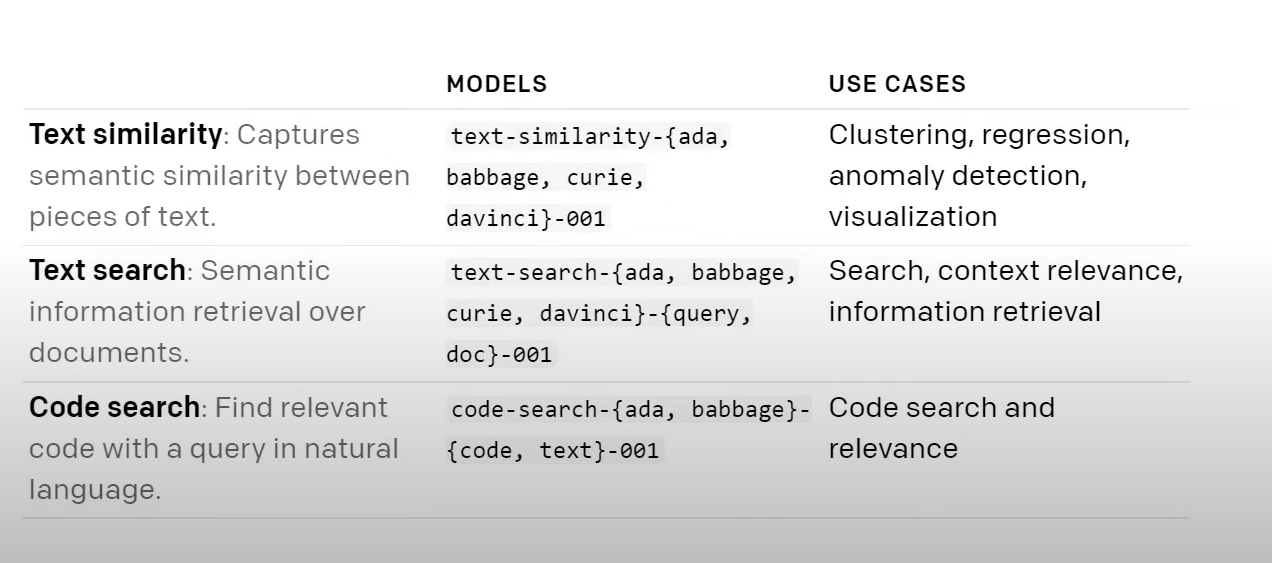

### Text Similarity

In [2]:
resp = openai.Embedding.create(
    input = ['eating food', 'I am hungry', 'I am travelling', 'exploring new places'],
    engine = 'text-similarity-davinci-001'
)

In [13]:
type(resp['data'])

list

In [14]:
resp['data']

[<OpenAIObject embedding at 0x130f8ef24f0> JSON: {
   "object": "embedding",
   "index": 0,
   "embedding": [
     -0.005568120628595352,
     0.007258897181600332,
     -0.01371690072119236,
     -0.00927384477108717,
     -0.007188978139311075,
     0.006054378114640713,
     -0.0110853910446167,
     -0.0014039482921361923,
     0.005390144418925047,
     -0.006724968086928129,
     -0.0069792200811207294,
     0.00574927544221282,
     0.005943142808973789,
     0.004948381334543228,
     0.00361991417594254,
     -0.01215960644185543,
     -0.012788880616426468,
     -0.005212167743593454,
     -0.01230580173432827,
     0.001368988654576242,
     -0.010265428572893143,
     -0.0024185730144381523,
     0.017873922362923622,
     0.006229176186025143,
     0.007379666902124882,
     0.0055712987668812275,
     0.008085216395556927,
     0.00019158291979692876,
     -0.013233821839094162,
     0.005806482397019863,
     -0.015992457047104836,
     -0.0019815771374851465,
     0.003

In [15]:
type(resp['data'][0])

openai.openai_object.OpenAIObject

In [18]:

len(resp['data'])

4

In [19]:
resp['data'][0].keys()

dict_keys(['object', 'index', 'embedding'])

In [20]:
resp['data'][0]['embedding']

[-0.005568120628595352,
 0.007258897181600332,
 -0.01371690072119236,
 -0.00927384477108717,
 -0.007188978139311075,
 0.006054378114640713,
 -0.0110853910446167,
 -0.0014039482921361923,
 0.005390144418925047,
 -0.006724968086928129,
 -0.0069792200811207294,
 0.00574927544221282,
 0.005943142808973789,
 0.004948381334543228,
 0.00361991417594254,
 -0.01215960644185543,
 -0.012788880616426468,
 -0.005212167743593454,
 -0.01230580173432827,
 0.001368988654576242,
 -0.010265428572893143,
 -0.0024185730144381523,
 0.017873922362923622,
 0.006229176186025143,
 0.007379666902124882,
 0.0055712987668812275,
 0.008085216395556927,
 0.00019158291979692876,
 -0.013233821839094162,
 0.005806482397019863,
 -0.015992457047104836,
 -0.0019815771374851465,
 0.0035722418688237667,
 -0.008040722459554672,
 -0.012623616494238377,
 -0.003975867293775082,
 0.00994125660508871,
 -0.005641218274831772,
 0.0039472635835409164,
 0.006852094084024429,
 -0.007983515970408916,
 -0.00512000173330307,
 -0.00523441

In [21]:
embedding_a = resp['data'][0]['embedding']
embedding_b = resp['data'][1]['embedding']
embedding_c = resp['data'][2]['embedding']
embedding_d = resp['data'][3]['embedding']

In [22]:

np.dot(embedding_a, embedding_b)

0.872262739242016